In [1]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# minimize
#     F = x[1]^2 + 4x[2]^2 -32x[2] + 64

# subject to:
#      x[1] + x[2] <= 7
#     -x[1] + 2x[2] <= 4
#      x[1] >= 0
#      x[2] >= 0
#      x[2] <= 4

# in matrix notation:
#     F = (1/2)*x.T*H*x + c*x + c0

# subject to:
#     Ax <= b

# where:
#     H = [[2, 0],
#          [0, 8]]

#     c = [0, -32]

#     c0 = 64

#     A = [[ 1, 1],
#          [-1, 2],
#          [-1, 0],
#          [0, -1],
#          [0,  1]]

#     b = [7,4,0,0,4]

H = np.array([[2., 0.],
              [0., 8.]])

c = np.array([0, -32])

c0 = 64

A = np.array([[ 1., 1.],
              [-1., 2.],
              [-1., 0.],
              [0., -1.],
              [0.,  1.]])

b = np.array([7., 4., 0., 0., 4.])

x0 = np.random.randn(2)

def loss(x, sign=1.):
    return sign * (0.5 * np.dot(x.T, np.dot(H, x))+ np.dot(c, x) + c0)

def jac(x, sign=1.):
    return sign * (np.dot(x.T, H) + c)

cons = {'type':'ineq',
        'fun':lambda x: b - np.dot(A,x),
        'jac':lambda x: -A}

opt = {'disp':False}

res_cons = optimize.minimize(loss, x0, jac=jac,constraints=cons,
                                 method='SLSQP', options=opt)

In [2]:
res_cons

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 7.999999999999652
       x: [ 2.000e+00  3.000e+00]
     nit: 4
     jac: [ 4.000e+00 -8.000e+00]
    nfev: 4
    njev: 4

In [3]:
class controller(object):
    def __init__(self):
        self.A = None 
        self.B = None 
        self.f = None 

        self.pred_horizon= None 
        self.control_horizon = None

        self.Q = None 
        self.R = None 
        self.F = None 

    def update_dynamics(self,A, B, f0):
        self.A = A 
        self.B = B 
        self.f0 = f0

    def set_cost(self, Q, R, F):
        self.Q = Q 
        self.R = R 
        self.F = F

    def discretize(self,dt):
        ''' 
        In application, there will be a linear term. That term replaces original xd by xd-c(x0).
        '''

        self.dt = dt

        G = np.zeros([self.B.shape[0]*self.pred_horizon,self.B.shape[1]*self.pred_horizon])


        tmp_B = dt * self.B 
        tmp_leading = tmp_B

        del_A = np.eye(self.B.shape[0]) + dt * self.A 

        self.del_A_pow = [del_A]

        for i in range(1,self.pred_horizon):
            G[(i)*self.B.shape[0]:(i+1)*self.B.shape[0],0:self.B.shape[1]] = -tmp_leading 
            for j in range(1,self.pred_horizon-i+1):
                G[(j+i-1)*self.B.shape[0]:(j+i)*self.B.shape[0],(j)*self.B.shape[1]:(j+1)*self.B.shape[1]] = tmp_B 
            
            self.del_A_pow.append(del_A @ self.del_A_pow[-1])
            tmp_B = del_A @ tmp_B
            tmp_leading = tmp_leading + tmp_B 

        Q_tilde = np.zeros([self.pred_horizon*self.A.shape[0],self.pred_horizon*self.A.shape[1]])

        Q_tilde[0:(self.pred_horizon-1)*self.A.shape[0],0:(self.pred_horizon-1)*self.A.shape[1]] = np.kron(np.eye(self.pred_horizon-1),self.Q)

        Q_tilde[(self.pred_horizon-1)*self.B.shape[0]:self.pred_horizon*self.B.shape[0],(self.pred_horizon-1)*self.B.shape[0]:self.pred_horizon*self.B.shape[0]] = self.F

        R_tilde = np.kron(np.eye(self.pred_horizon),self.R)

        self.G = G 
        self.M = G.T @ Q_tilde @ G + R_tilde
        self.Q_tilde = Q_tilde 

    def setup_qp_linear(self, x0, xd):
        x0 = x0.reshape(-1,1)
        xd = xd.reshape(-1,1)

        c = np.zeros([self.pred_horizon*self.B.shape[0],1])
        fmr_mat = np.eye(self.B.shape[0])
        for i in range(self.pred_horizon):
            f_minus_r = self.f0 - self.A @ x0
            c[i*self.B.shape[0]:(i+1)*self.B.shape[0]] = self.del_A_pow[i] @ x0 + self.dt * fmr_mat @ f_minus_r
            fmr_mat = fmr_mat + self.del_A_pow[i]

        xd_tilde = np.tile(xd,[self.pred_horizon,1])

        self.XD = (xd_tilde - c).T @ self.Q_tilde @ self.G

    def solve_qp(self):
        
        def loss(x):
            #print(np.dot(self.M, x).shape)
            #print(0.5 * np.dot(x, np.dot(self.M, x)))
            #return 0.5 * np.dot(x.T, np.dot(self.M, x)) - np.dot(self.XD, x)
            return 0.5 * np.dot(x.T, np.dot(self.M, x)) - np.dot(self.XD, x)
        

        def jac(x):
            return np.dot(x.T, self.M) - self.XD

        '''cons = {'type':'ineq',
                'fun':lambda x: b - np.dot(A,x),
                'jac':lambda x: -A}'''

        opt = {'disp':False}

        u0 = np.zeros([self.pred_horizon*self.B.shape[1],1]).reshape(-1)
        #print(u0.shape,"!!!")
        res_cons = optimize.minimize(loss,u0, jac=jac,
                                        method='SLSQP', options=opt)
        
        return res_cons.x

    def apply_control(self,x0,u):
        return self.dt * (self.A @ x0 + self.B @ u + self.f0) + x0 
    

In [4]:
ctrl = controller()

In [5]:
Q = np.array(
    [
        [0,0,0,0],
        [0,900.,0,30],
        [0,0,0,0],
        [0,30,0,1]
    ]
)
R = 1.*np.eye(2) 
F = Q 

ctrl.set_cost(Q,R,F)

In [6]:
CL = 2
def matrix_iterator(x0,u0):
    A = np.array([
        [0,    0,  (-np.sin(x0[2])*x0[3])[0],   (np.cos(x0[2]))[0]],
        [0,    0,  (np.cos(x0[2])*x0[3])[0],    (np.sin(x0[2]))[0]],
        [0,    0,  0,                      (np.tan(u0[1])/CL)[0]],
        [0,0,0,0]
    ]
    )

    B = np.array(
        [
        [0,0],
        [0,0],
        [0, (x0[3]/(np.cos(u0[1])**2 * CL))[0]],
        [0.5,0]
        ]
    )

    f0 = np.array([
        [(np.cos(x0[2])*x0[3])[0]],
        [(np.sin(x0[2])*x0[3])[0]],
        [((np.tan(u0[1])/CL)*x0[3])[0]],
        [(0.5*u0[0])[0]]
    ])

    return A,B,f0

x0 = np.array(
    [
        [0],
        [3.],
        [0],
        [20]
    ]
)

xd = np.array(
    [
        [0],
        [0.],
        [0],
        [20]
    ]
)

u0 = np.array(
    [
        [0],
        [0]
    ]
)


In [7]:
ctrl.pred_horizon = 30
xlist = [x0]
ulist = [u0]
for i in range(50):
    A,B,f0 = matrix_iterator(x0,u0)
    ctrl.update_dynamics(A,B,f0)
    ctrl.discretize(0.1)
    ctrl.setup_qp_linear(x0,xd)
    u = ctrl.solve_qp()
    u0 = u[0:2].reshape(-1,1)
    x0 = ctrl.apply_control(x0,u0)
    xlist.append(x0)
    ulist.append(u0)


In [8]:
import matplotlib.pyplot as plt

In [9]:
xm = np.array(xlist).squeeze(-1)
print(xm.shape)

(51, 4)


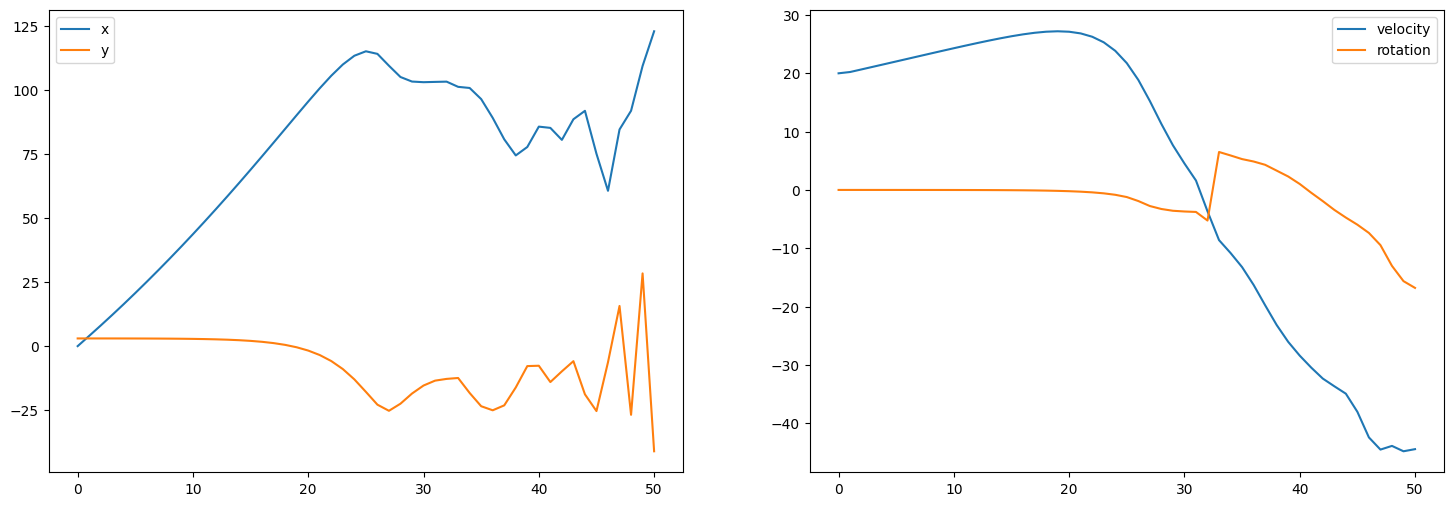

In [33]:
plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.plot(xm[:,0],label='x')
plt.plot(xm[:,1],label='y')
plt.legend()
plt.subplot(1,2,2)
plt.plot(xm[:,3],label='velocity')
plt.plot(xm[:,2],label='rotation')
plt.legend()

In [11]:
u_tilde = u.reshape(-1,2)

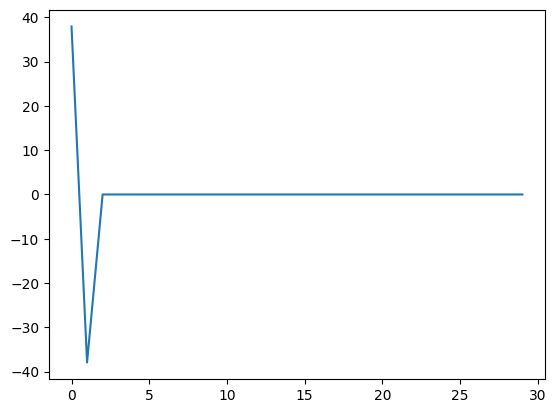

In [12]:
plt.plot(u_tilde[:,0])

In [13]:
u_tilde[6,0]

0.00010693867741438644